# SingleNNs Diagnostics

This script runs a number of diagnostics that evaluate the performance of both, SingleNNs & CausalSingleNNs offline (i.e., using test data).

### Setup

In [1]:
import sys
from utils.setup import SetupDiagnostics

# argv  = sys.argv[1:]
argv  = ["-c", "./nn_config/cfg_SingleNNs_Diagnostics.yml"]

setup = SetupDiagnostics(argv)


One can check both, attributes and methods in **setup** by, for example:\
**dir(setup)\
setup.__dict__** # setup.__dict__.keys() & setup.__dict__.values()

### Load Neural Networks

In [ ]:
from neural_networks.load_models import load_models
models = load_models(setup)

### Model Diagnostics

In [3]:
from neural_networks.model_diagnostics import ModelDiagnostics

In [4]:
from neural_networks.load_models import get_save_plot_folder

### Map plots

tphystnd-3.64


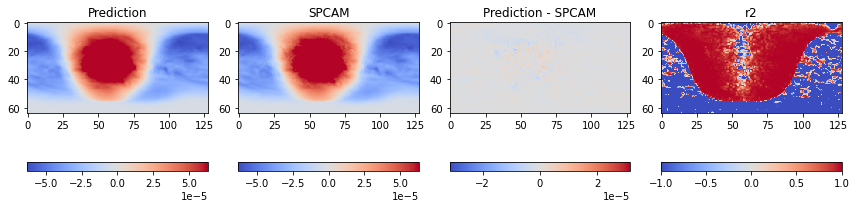

In [5]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
for var in models[model_type].keys():
    print(var)
    outPath = get_save_plot_folder(setup, model_type, var)
    md.plot_double_xy('mean', var, nTime=5, diff=True, stats='r2')#, save=outPath)
#     md.plot_double_xy('mean', var, nTime=5, diff=True, stats='mse')#, save=outPath)
#     md.plot_double_xy('mean', var, nTime=5, diff=True)#, save=outPath)
#     md.plot_double_xy(100, var, nTime=False, diff=True)#, save=outPath)
#     break

pc_alpha: 0.001
threshold: 0.15
variable: tphystnd-3.64



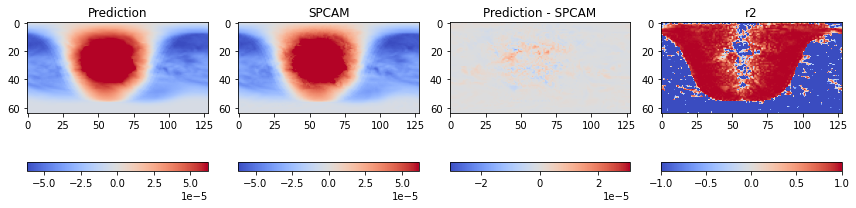

In [6]:
model_type = 'CausalSingleNN'
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            print(f"variable: {var}\n")
            md.plot_double_xy('mean', var, nTime=5, diff=True, stats='r2')#, save=outPath)
#             md.plot_double_xy('mean', var, nTime=5, diff=True, stats='mse')#, save=outPath)
#             md.plot_double_xy('mean', var, nTime=5, diff=True)#, save=outPath)
#             md.plot_double_xy(100, var, nTime=False, diff=True)#, save=outPath)
#             break

### Cross-section plots

tphystnd


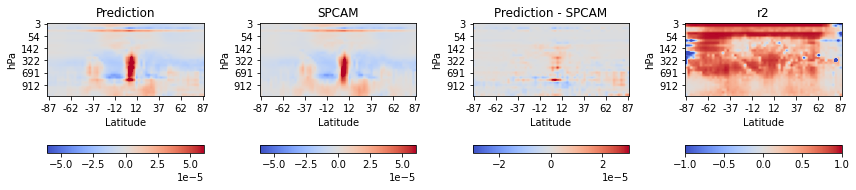

In [7]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
vars_to_ploted = []
for var in models[model_type].keys():
    if var.var.value not in vars_to_ploted and var.var.dimensions == 3:
        print(var.var.value)
        outPath = get_save_plot_folder(setup, model_type, var.var.value)
        var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
#        md.plot_double_yz(var,var_keys,itime=100,nTime=False,ilon=100,diff=True)
        md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='r2')
#         md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='mse')
        vars_to_ploted.append(var.var.value)
#         break

pc_alpha: 0.001
threshold: 0.15
tphystnd


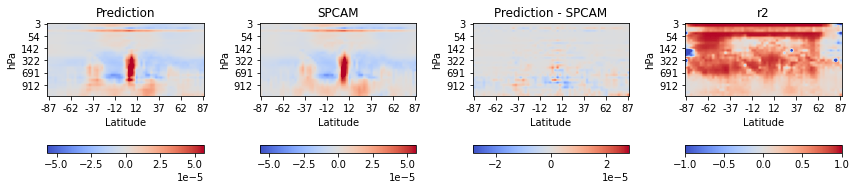

In [8]:
model_type = 'CausalSingleNN'
vars_to_ploted = []
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            if var.var.value not in vars_to_ploted and var.var.dimensions == 3:
                print(var.var.value)
                outPath = get_save_plot_folder(setup, model_type, var.var.value)
                var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                            if var.var.value in str(v)]
#                 md.plot_double_yz(var,var_keys,itime=100,nTime=False,ilon=100,diff=True)
                md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='r2')
#                 md.plot_double_yz(var,var_keys,itime='mean',nTime=10,ilon='mean',diff=True,stats='mse')
                vars_to_ploted.append(var.var.value)
#                 break

### Profile plots (within ModelDiagnostics)

tphystnd


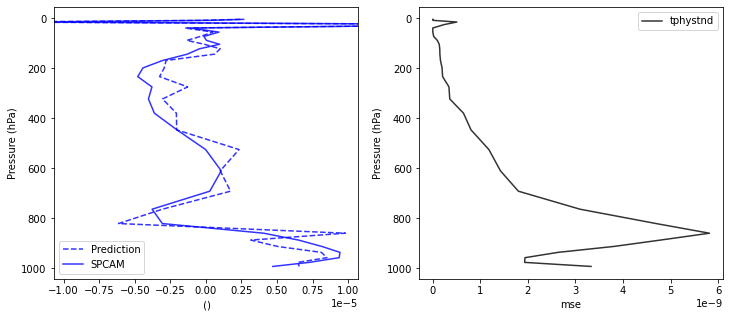

In [12]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
vars_to_plot = []
for var in models[model_type].keys():
    if var.var.value not in vars_to_plot and var.var.dimensions == 3:
        print(var.var.value)
        outPath = get_save_plot_folder(setup, model_type, var.var.value)
        var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
#         md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='r2')#,save=outPath)
        md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='mse')#,save=outPath)
        vars_to_plot.append(var.var.value)

pc_alpha: 0.001
threshold: 0.15
tphystnd


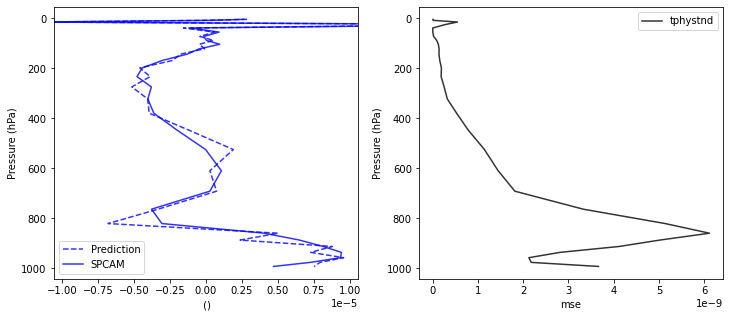

In [13]:
model_type = 'CausalSingleNN'
vars_to_plot = []
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            if var.var.value not in vars_to_plot and var.var.dimensions == 3:
                print(var.var.value)
                outPath = get_save_plot_folder(setup, model_type, var.var.value)
                var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                            if var.var.value in str(v)]
#                 md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='r2')#,save=outPath)
                md.plot_double_profile(var,var_keys,itime='range',nTime=5,stats='mse')#,save=outPath)
                vars_to_plot.append(var.var.value)

### Profile plots

In [9]:
from neural_networks.model_diagnostics import plot_profiles

Model: SingleNN; variable: tphystnd

Model: CausalSingleNN_0.001_0.15; variable: tphystnd



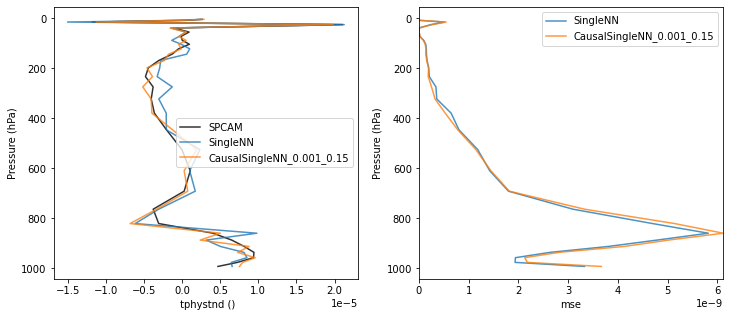

In [10]:
models_type = [setup.nn_type,["SingleNN","CausalSingleNN"]][setup.nn_type=='all']
vars_dict = {}
statsnm   = 'mse' # 'r2'; 'mse'
# Get profiles
for iMod, model_type in enumerate(models_type):
    if model_type == 'SingleNN':
        md = ModelDiagnostics(setup = setup, models=models[model_type])
        vars_dict[model_type] = {}
        for var in models[model_type].keys():
            if var.var.value not in vars_dict[model_type] and var.var.dimensions == 3:
                print(f'Model: {model_type}; variable: {var.var.value}\n')
                var_keys = [v for v in models[model_type].keys() if var.var.value in str(v)]
                truth, pred, stats = md.get_profiles(var, var_keys, itime='range', nTime=5, stats=statsnm)
                vars_dict[model_type][var.var.value] = {
                    'p':pred, 
                    't':truth, 
                    statsnm:(statsnm,stats), 
                    'lab':model_type
                }
    elif model_type == 'CausalSingleNN':
        for pc_alpha in models[model_type].keys():
            for threshold in models[model_type][pc_alpha].keys():
                c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                vars_dict[c_model_type] = {}
                md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
                for var in models[model_type][pc_alpha][threshold].keys():
                    if var.var.value not in vars_dict[c_model_type] and var.var.dimensions == 3:
                        print(f'Model: {c_model_type}; variable: {var.var.value}\n')
                        var_keys = [v for v in models[model_type][pc_alpha][threshold].keys() \
                                    if var.var.value in str(v)]
                        truth, pred, stats = md.get_profiles(
                            var, var_keys, itime='range', nTime=5, stats=statsnm
                        )
                        vars_dict[f'{c_model_type}'][var.var.value] = {
                            'p':pred, 
                            't':truth, 
                            statsnm:(statsnm,stats),
                            'lab':c_model_type,
                        }

# Plot profile
plot_profiles(
    vars_dict,
    varname='tphystnd',
    title='',
    unit='',
    save=False,
#     save='.',
    stats=statsnm
)

### Statistics

In [15]:
model_type = 'SingleNN'
md = ModelDiagnostics(setup = setup, models=models[model_type])
for var in models[model_type].keys():
    print(f"variable: {var}\n")
    md.compute_stats('range', var, nTime=5)
    stats = md.mean_stats()
    print(stats)
#     break

variable: tphystnd-3.64

          hor_tsqmean    hor_tmean      hor_mse     hor_tvar    hor_r2
TPHYSTND  2.33784e-09  2.66007e-06  2.43214e-12  2.33077e-09  0.998957


In [17]:
model_type = 'CausalSingleNN'
for pc_alpha in models[model_type].keys():
    print(f"pc_alpha: {pc_alpha}")
    for threshold in models[model_type][pc_alpha].keys():
        print(f"threshold: {threshold}")
        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])
        for var in models[model_type][pc_alpha][threshold].keys():
            print(f"variable: {var}\n")
            md.compute_stats('range', var, nTime=5)
            stats = md.mean_stats()
            print(stats)
#             break

pc_alpha: 0.001
threshold: 0.15
variable: tphystnd-3.64

          hor_tsqmean    hor_tmean      hor_mse     hor_tvar    hor_r2
TPHYSTND  2.33784e-09  2.66007e-06  5.51624e-12  2.33077e-09  0.997633
